# Getting live data from the StreamPipes data stream
In the last tutorial ([Extracting Data from the StreamPipes data lake](../2-extracting-data-from-the-streampipes-data-lake)) we learned how to extract the stored data from a StreamPipes data lake. This tutorial is about the StreamPipes data stream and shows how to get the live data from StreamPipes into Python. Therefore, we first create the `client` instance as before.

**Note**  
As of now we mainly developed the support for StreamPipes functions using NATS as messaging protocol. Consequently, this setup is tested most and should work flawlessly. Visit our [first-steps](../../getting-started/first-steps) page to see how to start StreamPipes accordingly.
Anyhow, you can also use the other [brokers](../../reference/functions/broker/broker) that are currently supported in StreamPipes Python.
In case you observe any problems, please reach out to us and file us an [issue](https://github.com/apache/streampipes/issues) on GitHub.

In [1]:
from streampipes.client import StreamPipesClient
from streampipes.client.config import StreamPipesClientConfig
from streampipes.client.credential_provider import StreamPipesApiKeyCredentials

In [ ]:
# You can install all required libraries for this tutorial with the following command
%pip install matplotlib ipython streampipes

In [2]:
import os

os.environ["SP_USERNAME"] = "admin@streampipes.apache.org"
os.environ["SP_API_KEY"] = "XXX"

# Use this if you work locally:
os.environ["BROKER-HOST"] = "localhost"  
os.environ["KAFKA-PORT"] = "9094" # When using Kafka as message broker

In [3]:
client_config = StreamPipesClientConfig(
    credential_provider=StreamPipesApiKeyCredentials(),
    host_address="localhost",
    port=80,
    https_disabled=True,
)
client = StreamPipesClient(client_config=client_config)

2022-12-14 10:43:37,664 - streampipes.client.client - [INFO] - [client.py:127] [_set_up_logging] - Logging successfully initialized with logging level INFO.


Now we can have a look at the available data streams. We can choose one or more stream to receive the data from and copy their `element_id`.

In [4]:
client.dataStreamApi.all().to_pandas()

2022-12-14 10:43:39,944 - streampipes.endpoint.endpoint - [INFO] - [endpoint.py:153] [_make_request] - Successfully retrieved all resources.


,element_id,name,description,icon_url,app_id,includes_assets,includes_locales,internally_managed,measurement_object,index,...,uri,dom,num_transport_protocols,num_measurement_capability,num_application_links,num_included_assets,num_connected_to,num_category,num_event_properties,num_included_locales
0,urn:streampipes.apache.org:eventstream:HHoidJ,Test2,,None,None,False,False,True,None,0,...,urn:streampipes.apache.org:eventstream:HHoidJ,None,1,0,0,0,0,0,7,0
1,urn:streampipes.apache.org:eventstream:uPDKLI,Test,,None,None,False,False,True,None,0,...,urn:streampipes.apache.org:eventstream:uPDKLI,None,1,0,0,0,0,0,7,0


Next we can create a StreamPipesFunction. For this we need to implement the 3 following methods:
- `onServiceStarted` is called when the function gets started. There you can use the given meta information of the `FunctionContext` to initialize the function.
- `onEvent` is called when ever a new event arrives. The `event` contains the live data and you can use the `streamId` to identify a stream if the function is connected to multiple data streams.
- `onServiceStopped` is called when the function gets stopped.

For this tutorial we just create a function that saves every new event in a `pandas DataFrame` and plots the first column of the `DataFrame` when the function gets stopped.  
  
(If you want to use the same structure as in Java you can overwrite the `getFunctionId` and `requiredStreamIds` methods instead of using the `FunctionDefinition`)

In [5]:
from typing import Dict, Any
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from streampipes.functions.function_handler import FunctionHandler
from streampipes.functions.registration import Registration
from streampipes.functions.streampipes_function import StreamPipesFunction
from streampipes.functions.utils.function_context import FunctionContext
from streampipes.model.resource.function_definition import FunctionDefinition, FunctionId

class ExampleFunction(StreamPipesFunction):
    def __init__(self, function_definition: FunctionDefinition) -> None:
        super().__init__(function_definition)
        # Create the Dataframe to save the live data
        self.df = pd.DataFrame()

    def onServiceStarted(self, context: FunctionContext):
        # Get the name of the timestamp field
        for event_property in context.schema[context.streams[0]].event_schema.event_properties:
            if event_property.property_scope == "HEADER_PROPERTY":
                self.timestamp = event_property.runtime_name

    def onEvent(self, event: Dict[str, Any], streamId: str):
        # Convert the unix timestamp to datetime
        event[self.timestamp] = datetime.fromtimestamp(event[self.timestamp] / 1000)
        # Add every value of the event to the DataFrame
        self.df = pd.concat(
            [self.df, pd.DataFrame({key: [event[key]] for key in event.keys()}).set_index(self.timestamp)]
        )

    def onServiceStopped(self):
        # Plot the first column of the Dataframe
        plt.figure(figsize=(10, 5))
        plt.xlabel(self.timestamp)
        plt.ylabel(self.df.columns[0])
        plt.plot(self.df.iloc[:, 0])
        plt.show()

Now we can start the function. First we create an instance of the `ExampleFunction` and insert the `element_id` of the stream which data we want to consume. Then we have to register this function and we can start all functions by initializing the `FunctionHandler`. (it's also possible to register multiple functions with `.register(...).register(...)`)

In [6]:
example_function = ExampleFunction(
    FunctionDefinition(
        function_id=FunctionId(id="example-function"),
        consumed_streams=["urn:streampipes.apache.org:eventstream:uPDKLI"]
    )
)

registration = Registration()
registration.register(example_function)

function_handler = FunctionHandler(registration, client)
function_handler.initializeFunctions()

2022-12-14 10:43:42,810 - streampipes.endpoint.endpoint - [INFO] - [endpoint.py:153] [_make_request] - Successfully retrieved all resources.
2022-12-14 10:43:42,812 - streampipes.functions.function_handler - [INFO] - [function_handler.py:82] [initializeFunctions] - Using NatsBroker for <__main__.ExampleFunction object at 0x000001F2EF298D90>


The `DataFrame` of the `ExampleFunction` gets updated whenever a new event arrives. Let's test this by executing the cell below.  

In [7]:
import asyncio
from asyncio.exceptions import CancelledError
from IPython.display import clear_output

while True:
    clear_output(wait=True)
    display(example_function.df)
    try:
        await asyncio.sleep(1)
    except CancelledError:
        break

,mass_flow,density,volume_flow,sensor_fault_flags,temperature,sensorId
timestamp,,,,,,
2022-12-14 10:43:43.357,10.955496,47.546290,1.001985,False,44.993413,flowrate02
2022-12-14 10:43:44.371,6.499040,44.392069,2.034402,False,41.232352,flowrate02
2022-12-14 10:43:45.382,10.168300,41.192146,9.724287,False,46.812779,flowrate02
2022-12-14 10:43:46.395,10.849059,50.086308,5.832691,False,45.860412,flowrate02
2022-12-14 10:43:47.410,3.081855,47.254246,8.860531,False,50.505801,flowrate02
...,...,...,...,...,...,...
2022-12-14 10:44:43.920,1.803572,41.978894,10.294002,False,47.820239,flowrate02
2022-12-14 10:44:44.932,1.967062,42.212883,3.237440,False,49.047258,flowrate02
2022-12-14 10:44:45.934,4.457819,47.561256,0.315024,False,40.223413,flowrate02


The `while` loop just displays the the `DataFrame` every second until the cell is stopped. We could achieve the same result manually by executing `example_function.df` repeatedly.

You can stop the functions whenever you want by executing the command below.

2022-12-14 10:44:53,309 - streampipes.functions.broker.nats_broker - [INFO] - [nats_broker.py:67] [disconnect] - Stopped connection to stream: urn:streampipes.apache.org:eventstream:uPDKLI


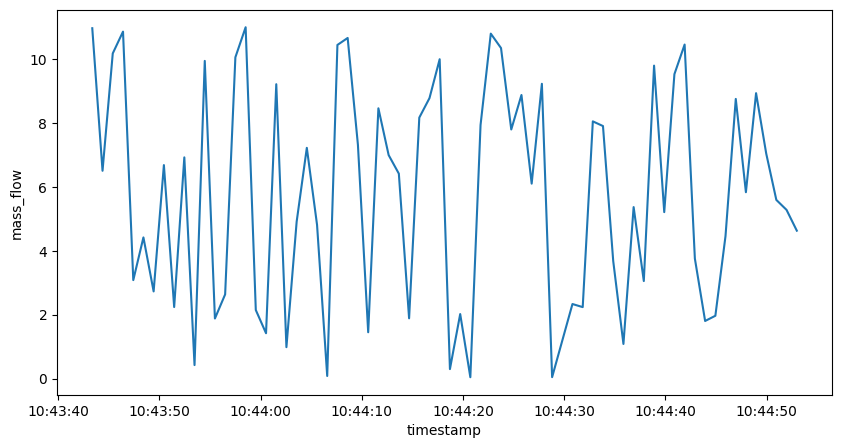

In [ ]:
function_handler.disconnect()

That's enough for this tutorial. Now you can try to write your own `StreamPipesFunction`. All you need to do is creating a new class, implementing the 4 required methods and registering the function.


Want to see more exciting use cases you can achieve with StreamPipes functions in Python? Then don't hesitate and jump to our [next tutorial](../4-using-online-machine-learning-on-a-streampipes-data-stream) on applying online machine learning algorithms to StreamPipes data streams with [River](https://riverml.xyz).

How do you like this tutorial?
We hope you like it and would love to receive some feedback from you.
Just go to our [GitHub discussion page](https://github.com/apache/streampipes/discussions) and let us know your impression.
We'll read and react to them all, we promise!